In [ ]:
!pip install matplotlib timm torch torchvision segmentation-models-pytorch pandas scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 132.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 104.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 103.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 14.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Unin

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as T
import os
import pandas as pd
from PIL import Image
import timm
from tqdm import tqdm
from time import time
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Basic EDA

In [4]:
# Function to load and analyze CSV files
def analyze_groundtruth(csv_path):
    df = pd.read_csv(csv_path)
    print(f"\nEDA for {os.path.basename(csv_path)}:")
    print(df.head())
    print(df.info())

    # Map melanoma to benign/malignant
    df['cancer_type'] = df['melanoma'].map({0: 'benign', 1: 'malignant'})

    # Value counts
    value_counts = df['cancer_type'].value_counts()
    print("\nLabel Distribution:")
    print(value_counts)

    # Check imbalance
    total = len(df)
    benign_count = value_counts.get('benign', 0)
    malignant_count = value_counts.get('malignant', 0)
    benign_percent = (benign_count / total) * 100
    malignant_percent = (malignant_count / total) * 100
    print(f"\nImbalance Check:")
    print(f"Benign (melanoma=0): {benign_count} ({benign_percent:.2f}%)")
    print(f"Malignant (melanoma=1): {malignant_count} ({malignant_percent:.2f}%)")
    print(f"Imbalance Ratio (Malignant/Benign): {malignant_count / benign_count:.2f}")
    print('\n')
    print('-' * 20)
    print('\n')
# Analyze all ground truth files
csv_files = [
    '/content/drive/MyDrive/DL_ISIC_2017_dataset/ISIC-2017_Training_Part3_GroundTruth.csv',
    '/content/drive/MyDrive/DL_ISIC_2017_dataset/ISIC-2017_Validation_Part3_GroundTruth.csv',
    '/content/drive/MyDrive/DL_ISIC_2017_dataset/ISIC-2017_Test_v2_Part3_GroundTruth.csv'
]

for csv_file in csv_files:
    if os.path.exists(csv_file):
        analyze_groundtruth(csv_file)
    else:
        print(f"Warning: {csv_file} not found.")


EDA for ISIC-2017_Training_Part3_GroundTruth.csv:
       image_id  melanoma  seborrheic_keratosis
0  ISIC_0000000       0.0                   0.0
1  ISIC_0000001       0.0                   0.0
2  ISIC_0000002       1.0                   0.0
3  ISIC_0000003       0.0                   0.0
4  ISIC_0000004       1.0                   0.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   image_id              2000 non-null   object 
 1   melanoma              2000 non-null   float64
 2   seborrheic_keratosis  2000 non-null   float64
dtypes: float64(2), object(1)
memory usage: 47.0+ KB
None

Label Distribution:
cancer_type
benign       1626
malignant     374
Name: count, dtype: int64

Imbalance Check:
Benign (melanoma=0): 1626 (81.30%)
Malignant (melanoma=1): 374 (18.70%)
Imbalance Ratio (Malignant/Benign): 0.23


--------------

# ISIC data preprocessing & DataLoader

In [5]:
class ISICDataset(Dataset):
    def __init__(self, image_dir, mask_dir, csv_path, transform=None, is_validation=False, is_test=False):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.is_validation = is_validation
        self.is_test = is_test

        self.labels_df = pd.read_csv(csv_path)
        self.labels_dict = dict(zip(self.labels_df['image_id'], self.labels_df['melanoma']))

        self.images = sorted([
            f for f in os.listdir(image_dir)
            if f.endswith('.jpg')
        ])

        self.label_map = {0: 0, 1: 1}  # melanoma 0 -> benign 0, melanoma 1 -> malignant 1

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_id = img_name.replace('.jpg', '')

        img_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, f"{img_id}_segmentation.png")

        try:
            image = Image.open(img_path).convert('RGB')
            mask = Image.open(mask_path).convert('L')
        except Exception as e:
            print(f"Error loading image/mask {img_id}: {e}")
            # Return a default image/mask to skip corrupted files
            image = Image.new('RGB', (224, 224))
            mask = Image.new('L', (224, 224))

        label = self.labels_dict.get(img_id, 0)  # Default to 0 (benign) if not found

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        mask = (mask > 0).float()
        label_tensor = torch.tensor(label, dtype=torch.long)

        return image, mask, label_tensor

In [6]:
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
])

In [7]:
# Dataset paths for ISIC 2017
train_image_dir = '/content/drive/MyDrive/DL_ISIC_2017_dataset/ISIC-2017_Training_Data'
train_mask_dir = '/content/drive/MyDrive/DL_ISIC_2017_dataset/ISIC-2017_Training_Part1_GroundTruth'
val_image_dir = '/content/drive/MyDrive/DL_ISIC_2017_dataset/ISIC-2017_Validation_Data'
val_mask_dir = '/content/drive/MyDrive/DL_ISIC_2017_dataset/ISIC-2017_Validation_Part1_GroundTruth'
test_image_dir = '/content/drive/MyDrive/DL_ISIC_2017_dataset/ISIC-2017_Test_v2_Data'
test_mask_dir = '/content/drive/MyDrive/DL_ISIC_2017_dataset/ISIC-2017_Test_v2_Part1_GroundTruth'
train_csv_path = '/content/drive/MyDrive/DL_ISIC_2017_dataset/ISIC-2017_Training_Part3_GroundTruth.csv'
val_csv_path = '/content/drive/MyDrive/DL_ISIC_2017_dataset/ISIC-2017_Validation_Part3_GroundTruth.csv'
test_csv_path = '/content/drive/MyDrive/DL_ISIC_2017_dataset/ISIC-2017_Test_v2_Part3_GroundTruth.csv'

# Create datasets
train_dataset = ISICDataset(train_image_dir, train_mask_dir, train_csv_path, transform, is_validation=False)
val_dataset = ISICDataset(val_image_dir, val_mask_dir, val_csv_path, transform, is_validation=True)
test_dataset = ISICDataset(test_image_dir, test_mask_dir, test_csv_path, transform, is_test=True)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

# Quick test of DataLoader
# images, masks, labels = next(iter(train_loader))
# print(f"Images batch shape: {images.shape}")  # [64, 3, 224, 224]
# print(f"Masks batch shape: {masks.shape}")    # [64, 1, 224, 224]
# print(f"Labels: {labels}")                   # [64]

# ViT Encoder output shape

# U-Net Decoder

# Full ViT + U-Net Hybrid Model

In [8]:
class UNetDecoder(nn.Module):
    def __init__(self, in_channels=768, out_channels=1):
        super(UNetDecoder, self).__init__()
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels, 512, 2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.up2 = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.up3 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.up4 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.final_conv = nn.Conv2d(64, out_channels, 1)

    def forward(self, x):
        x = self.up1(x)
        x = self.up2(x)
        x = self.up3(x)
        x = self.up4(x)
        x = self.final_conv(x)
        return x

class ViT_UNet(nn.Module):
    def __init__(self, vit_encoder, decoder, num_labels=2, input_size=224, patch_size=16):
        super(ViT_UNet, self).__init__()
        self.encoder = vit_encoder
        self.decoder = decoder
        self.classification_head = nn.Sequential(
            nn.Linear(768, num_labels)
        )
        self.input_size = input_size
        self.patch_size = patch_size
        self.expected_grid_size = input_size // patch_size
        self.expected_seq_len = self.expected_grid_size * self.expected_grid_size  # 196 for 14x14

        # Ensure model parameters are in float32
        self.encoder = self.encoder.float()
        self.decoder = self.decoder.float()
        self.classification_head = self.classification_head.float()

    def forward(self, x):
        B = x.shape[0]
        x = self.encoder.patch_embed(x)
        x = self.encoder.pos_drop(x)

        for blk in self.encoder.blocks:
            x = blk(x)
        x = self.encoder.norm(x)  # Shape: [B, seq_len, 768]

        # Check if CLS token is present
        seq_len = x.shape[1]
        cls_token = None
        if seq_len == (self.expected_seq_len + 1):  # CLS token + patches (e.g., 197 for 14x14 grid)
            cls_token = x[:, 0, :]  # [B, 768]
            x = x[:, 1:, :]         # [B, expected_seq_len, 768]
        else:  # No CLS token, use all patches or mean for classification
            cls_token = x.mean(dim=1)  # [B, 768] as a fallback for classification
            x = x  # Use all patches for segmentation

        num_patches = x.shape[1]  # Actual number of patches
        grid_size = int(num_patches ** 0.5)  # Dynamically compute grid size

        x = x.permute(0, 2, 1).contiguous()  # [B, 768, num_patches]
        x = x.view(B, 768, grid_size, grid_size)  # Dynamically reshape

        seg_out = self.decoder(x)  # [B, 1, 224, 224]
        cls_out = self.classification_head(cls_token).float()  # Ensure cls_out is float32

        return seg_out, cls_out

# Encoder
vit_encoder = timm.create_model('vit_base_patch16_224', pretrained=True)
vit_encoder.patch_embed = vit_encoder.patch_embed
vit_encoder.pos_drop = vit_encoder.pos_drop
vit_encoder.blocks = vit_encoder.blocks
vit_encoder.norm = vit_encoder.norm

# Model
decoder = UNetDecoder().to(device)
model = ViT_UNet(vit_encoder, decoder, input_size=224, patch_size=16).to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [12]:
# Compute class weights for weighted cross-entropy
train_labels_df = pd.read_csv(train_csv_path)
class_counts = train_labels_df['melanoma'].value_counts()
total_samples = len(train_labels_df)
class_weights = torch.tensor([total_samples / (2 * class_counts[0]), total_samples / (2 * class_counts[1])], dtype=torch.float32).to(device)
print(f"Class Weights (Benign, Malignant): {class_weights.tolist()}")

# Define losses and optimizer
bce_loss = nn.BCEWithLogitsLoss()
classification_loss = nn.CrossEntropyLoss(weight=class_weights)  # Weighted cross-entropy
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Dice Loss
def dice_loss(pred, target, smooth=1.):
    pred = torch.sigmoid(pred)
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    return 1 - ((2. * intersection + smooth) / (pred.sum() + target.sum() + smooth))

Class Weights (Benign, Malignant): [0.615006148815155, 2.6737968921661377]


# Training Loop + Loss Function

In [13]:
EPOCHS = 50
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

for epoch in range(EPOCHS):
    # Training Phase
    model.train()
    epoch_loss = 0.0
    train_correct = 0
    train_total = 0
    start_time = time()

    print(f"Starting epoch {epoch+1}...")
    for batch_idx, (images, masks, labels) in enumerate(train_loader):
        images = images.to(device)
        masks = masks.to(device)
        labels = labels.to(device).long()

        optimizer.zero_grad()
        seg_out, cls_out = model(images)

        loss_bce = bce_loss(seg_out, masks)
        loss_dice = dice_loss(seg_out, masks)
        loss_cls = classification_loss(cls_out, labels)

        loss = loss_bce + loss_dice + loss_cls
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * images.size(0)
        preds = torch.argmax(cls_out, dim=1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)

    epoch_loss = epoch_loss / len(train_loader.dataset)
    train_acc = 100. * train_correct / train_total
    train_losses.append(epoch_loss)
    train_accuracies.append(train_acc)

    # Validation Phase (run every 2 epochs)
    val_loss = 0.0
    val_acc = 0.0
    if (epoch + 1) % 2 == 0:  # Run validation every 2 epochs
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, masks, labels in val_loader:
                images = images.to(device)
                masks = masks.to(device)
                labels = labels.to(device).long()

                seg_out, cls_out = model(images)

                loss_bce = bce_loss(seg_out, masks)
                loss_dice = dice_loss(seg_out, masks)
                loss_cls = classification_loss(cls_out, labels)

                loss = loss_bce + loss_dice + loss_cls
                val_loss += loss.item() * images.size(0)

                preds = torch.argmax(cls_out, dim=1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_loss = val_loss / len(val_loader.dataset)
        val_acc = 100. * val_correct / val_total

    valid_losses.append(val_loss)
    valid_accuracies.append(val_acc)

    # Save model after every epoch
    model_save_path = f'vit_unet_model_epoch_{epoch+1}.pth'
    torch.save(model.state_dict(), model_save_path)
    torch.save(model.state_dict(), f'/content/drive/MyDrive/{model_save_path}')
    print(f"Model saved to {model_save_path} and Google Drive")

    epoch_time = time() - start_time
    print(f"Epoch [{epoch+1}/{EPOCHS}] | "
          f"Train Loss: {epoch_loss:.4f} | Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}% | "
          f"Epoch Time: {epoch_time:.3f}s")

print("Training completed!")

# Save the final model
final_model_path = 'vit_unet_model.pth'
torch.save(model.state_dict(), final_model_path)
torch.save(model.state_dict(), f'/content/drive/MyDrive/{final_model_path}')
print(f"Final model saved to {final_model_path} and Google Drive")

Starting epoch 1...
Model saved to vit_unet_model_epoch_1.pth and Google Drive
Epoch [1/50] | Train Loss: 2.2911 | Train Acc: 55.05% | Val Loss: 0.0000 | Val Acc: 0.00% | Epoch Time: 88.143s
Starting epoch 2...
Model saved to vit_unet_model_epoch_2.pth and Google Drive
Epoch [2/50] | Train Loss: 1.8791 | Train Acc: 53.50% | Val Loss: 1.6939 | Val Acc: 42.67% | Epoch Time: 109.255s
Starting epoch 3...
Model saved to vit_unet_model_epoch_3.pth and Google Drive
Epoch [3/50] | Train Loss: 1.5858 | Train Acc: 54.30% | Val Loss: 0.0000 | Val Acc: 0.00% | Epoch Time: 93.669s
Starting epoch 4...
Model saved to vit_unet_model_epoch_4.pth and Google Drive
Epoch [4/50] | Train Loss: 1.3664 | Train Acc: 62.55% | Val Loss: 1.3636 | Val Acc: 76.00% | Epoch Time: 113.192s
Starting epoch 5...
Model saved to vit_unet_model_epoch_5.pth and Google Drive
Epoch [5/50] | Train Loss: 1.0684 | Train Acc: 65.10% | Val Loss: 0.0000 | Val Acc: 0.00% | Epoch Time: 92.768s
Starting epoch 6...
Model saved to vit_un

In [16]:
from sklearn.metrics import roc_auc_score
import numpy as np

def calculate_dice(pred, target, smooth=1.):
    pred = torch.sigmoid(pred)  # Shape: [batch_size, 1, H, W]
    pred = (pred > 0.5).float()  # Binarize predictions
    target = target.float()  # Ensure target is float, Shape: [batch_size, 1, H, W]

    # Compute intersection and union per sample
    intersection = (pred * target).sum(dim=(1, 2, 3))  # Sum over H, W dimensions
    pred_sum = pred.sum(dim=(1, 2, 3))
    target_sum = target.sum(dim=(1, 2, 3))

    # Compute Dice score per sample
    dice = (2. * intersection + smooth) / (pred_sum + target_sum + smooth)  # Shape: [batch_size]
    return dice

def calculate_iou(pred, target, smooth=1e-6):
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()
    target = target.float()

    intersection = (pred * target).sum(dim=(1, 2, 3))
    union = pred.sum(dim=(1, 2, 3)) + target.sum(dim=(1, 2, 3)) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou

def test_model(model, test_loader, device):
    model.eval()
    all_probs = []
    all_labels = []
    dice_scores = []
    iou_scores = []
    test_loss = 0.0
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for images, masks, labels in test_loader:
            images = images.to(device)
            masks = masks.to(device)
            labels = labels.to(device).long()

            seg_out, cls_out = model(images)

            # Segmentation metrics
            batch_dice = calculate_dice(seg_out, masks)  # Now returns [batch_size]
            batch_iou = calculate_iou(seg_out, masks)    # Now returns [batch_size]
            dice_scores.extend(batch_dice.cpu().numpy())
            iou_scores.extend(batch_iou.cpu().numpy())

            # Classification metrics
            probs = torch.softmax(cls_out, dim=1)[:, 1]  # Probability of malignant class
            preds = torch.argmax(cls_out, dim=1)
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Loss
            loss_bce = bce_loss(seg_out, masks)
            loss_dice = dice_loss(seg_out, masks)
            loss_cls = classification_loss(cls_out, labels)
            loss = loss_bce + loss_dice + loss_cls
            test_loss += loss.item() * images.size(0)

            test_correct += (preds == labels).sum().item()
            test_total += labels.size(0)

    # Average metrics
    avg_dice = np.mean(dice_scores)
    avg_iou = np.mean(iou_scores)
    auc = roc_auc_score(all_labels, all_probs)
    test_loss = test_loss / len(test_loader.dataset)
    test_acc = 100. * test_correct / test_total

    print(f"Final Test Set Metrics:")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.2f}%")
    print(f"Average Dice Score: {avg_dice:.4f}")
    print(f"Average IoU Score: {avg_iou:.4f}")
    print(f"AUC for Classification: {auc:.4f}")

    return test_loss, test_acc, avg_dice, avg_iou, auc

# Run after training
model.load_state_dict(torch.load('vit_unet_model_epoch_20.pth'))
model.to(device)
test_loss, test_acc, avg_dice, avg_iou, auc = test_model(model, test_loader, device)

Final Test Set Metrics:
Test Loss: 1.4048
Test Accuracy: 71.50%
Average Dice Score: 0.7403
Average IoU Score: 0.6424
AUC for Classification: 0.7440


In [19]:
from sklearn.metrics import roc_auc_score
import numpy as np

def calculate_dice(pred, target, smooth=1.):
    pred = torch.sigmoid(pred)  # Shape: [batch_size, 1, H, W]
    pred = (pred > 0.5).float()  # Binarize predictions
    target = target.float()  # Ensure target is float, Shape: [batch_size, 1, H, W]

    # Compute intersection and union per sample
    intersection = (pred * target).sum(dim=(1, 2, 3))  # Sum over H, W dimensions
    pred_sum = pred.sum(dim=(1, 2, 3))
    target_sum = target.sum(dim=(1, 2, 3))

    # Compute Dice score per sample
    dice = (2. * intersection + smooth) / (pred_sum + target_sum + smooth)  # Shape: [batch_size]
    return dice

def calculate_iou(pred, target, smooth=1e-6):
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()
    target = target.float()

    intersection = (pred * target).sum(dim=(1, 2, 3))
    union = pred.sum(dim=(1, 2, 3)) + target.sum(dim=(1, 2, 3)) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou

def test_model(model, test_loader, device):
    model.eval()
    all_probs = []
    all_labels = []
    dice_scores = []
    iou_scores = []
    test_loss = 0.0
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for images, masks, labels in test_loader:
            images = images.to(device)
            masks = masks.to(device)
            labels = labels.to(device).long()

            seg_out, cls_out = model(images)

            # Segmentation metrics
            batch_dice = calculate_dice(seg_out, masks)  # Now returns [batch_size]
            batch_iou = calculate_iou(seg_out, masks)    # Now returns [batch_size]
            dice_scores.extend(batch_dice.cpu().numpy())
            iou_scores.extend(batch_iou.cpu().numpy())

            # Classification metrics
            probs = torch.softmax(cls_out, dim=1)[:, 1]  # Probability of malignant class
            preds = torch.argmax(cls_out, dim=1)
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Loss
            loss_bce = bce_loss(seg_out, masks)
            loss_dice = dice_loss(seg_out, masks)
            loss_cls = classification_loss(cls_out, labels)
            loss = loss_bce + loss_dice + loss_cls
            test_loss += loss.item() * images.size(0)

            test_correct += (preds == labels).sum().item()
            test_total += labels.size(0)

    # Average metrics
    avg_dice = np.mean(dice_scores)
    avg_iou = np.mean(iou_scores)
    auc = roc_auc_score(all_labels, all_probs)
    test_loss = test_loss / len(test_loader.dataset)
    test_acc = 100. * test_correct / test_total

    print(f"Final Test Set Metrics:")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.2f}%")
    print(f"Average Dice Score: {avg_dice:.4f}")
    print(f"Average IoU Score: {avg_iou:.4f}")
    print(f"AUC for Classification: {auc:.4f}")

    return test_loss, test_acc, avg_dice, avg_iou, auc

# Run after training
model.load_state_dict(torch.load('vit_unet_model_epoch_30.pth'))
model.to(device)
test_loss, test_acc, avg_dice, avg_iou, auc = test_model(model, test_loader, device)

Final Test Set Metrics:
Test Loss: 1.8503
Test Accuracy: 72.00%
Average Dice Score: 0.7382
Average IoU Score: 0.6409
AUC for Classification: 0.6894


In [20]:
from sklearn.metrics import roc_auc_score
import numpy as np

def calculate_dice(pred, target, smooth=1.):
    pred = torch.sigmoid(pred)  # Shape: [batch_size, 1, H, W]
    pred = (pred > 0.5).float()  # Binarize predictions
    target = target.float()  # Ensure target is float, Shape: [batch_size, 1, H, W]

    # Compute intersection and union per sample
    intersection = (pred * target).sum(dim=(1, 2, 3))  # Sum over H, W dimensions
    pred_sum = pred.sum(dim=(1, 2, 3))
    target_sum = target.sum(dim=(1, 2, 3))

    # Compute Dice score per sample
    dice = (2. * intersection + smooth) / (pred_sum + target_sum + smooth)  # Shape: [batch_size]
    return dice

def calculate_iou(pred, target, smooth=1e-6):
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()
    target = target.float()

    intersection = (pred * target).sum(dim=(1, 2, 3))
    union = pred.sum(dim=(1, 2, 3)) + target.sum(dim=(1, 2, 3)) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou

def test_model(model, test_loader, device):
    model.eval()
    all_probs = []
    all_labels = []
    dice_scores = []
    iou_scores = []
    test_loss = 0.0
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for images, masks, labels in test_loader:
            images = images.to(device)
            masks = masks.to(device)
            labels = labels.to(device).long()

            seg_out, cls_out = model(images)

            # Segmentation metrics
            batch_dice = calculate_dice(seg_out, masks)  # Now returns [batch_size]
            batch_iou = calculate_iou(seg_out, masks)    # Now returns [batch_size]
            dice_scores.extend(batch_dice.cpu().numpy())
            iou_scores.extend(batch_iou.cpu().numpy())

            # Classification metrics
            probs = torch.softmax(cls_out, dim=1)[:, 1]  # Probability of malignant class
            preds = torch.argmax(cls_out, dim=1)
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Loss
            loss_bce = bce_loss(seg_out, masks)
            loss_dice = dice_loss(seg_out, masks)
            loss_cls = classification_loss(cls_out, labels)
            loss = loss_bce + loss_dice + loss_cls
            test_loss += loss.item() * images.size(0)

            test_correct += (preds == labels).sum().item()
            test_total += labels.size(0)

    # Average metrics
    avg_dice = np.mean(dice_scores)
    avg_iou = np.mean(iou_scores)
    auc = roc_auc_score(all_labels, all_probs)
    test_loss = test_loss / len(test_loader.dataset)
    test_acc = 100. * test_correct / test_total

    print(f"Final Test Set Metrics:")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.2f}%")
    print(f"Average Dice Score: {avg_dice:.4f}")
    print(f"Average IoU Score: {avg_iou:.4f}")
    print(f"AUC for Classification: {auc:.4f}")

    return test_loss, test_acc, avg_dice, avg_iou, auc

# Run after training
model.load_state_dict(torch.load('vit_unet_model_epoch_24.pth'))
model.to(device)
test_loss, test_acc, avg_dice, avg_iou, auc = test_model(model, test_loader, device)

Final Test Set Metrics:
Test Loss: 1.9017
Test Accuracy: 74.17%
Average Dice Score: 0.7337
Average IoU Score: 0.6407
AUC for Classification: 0.6683


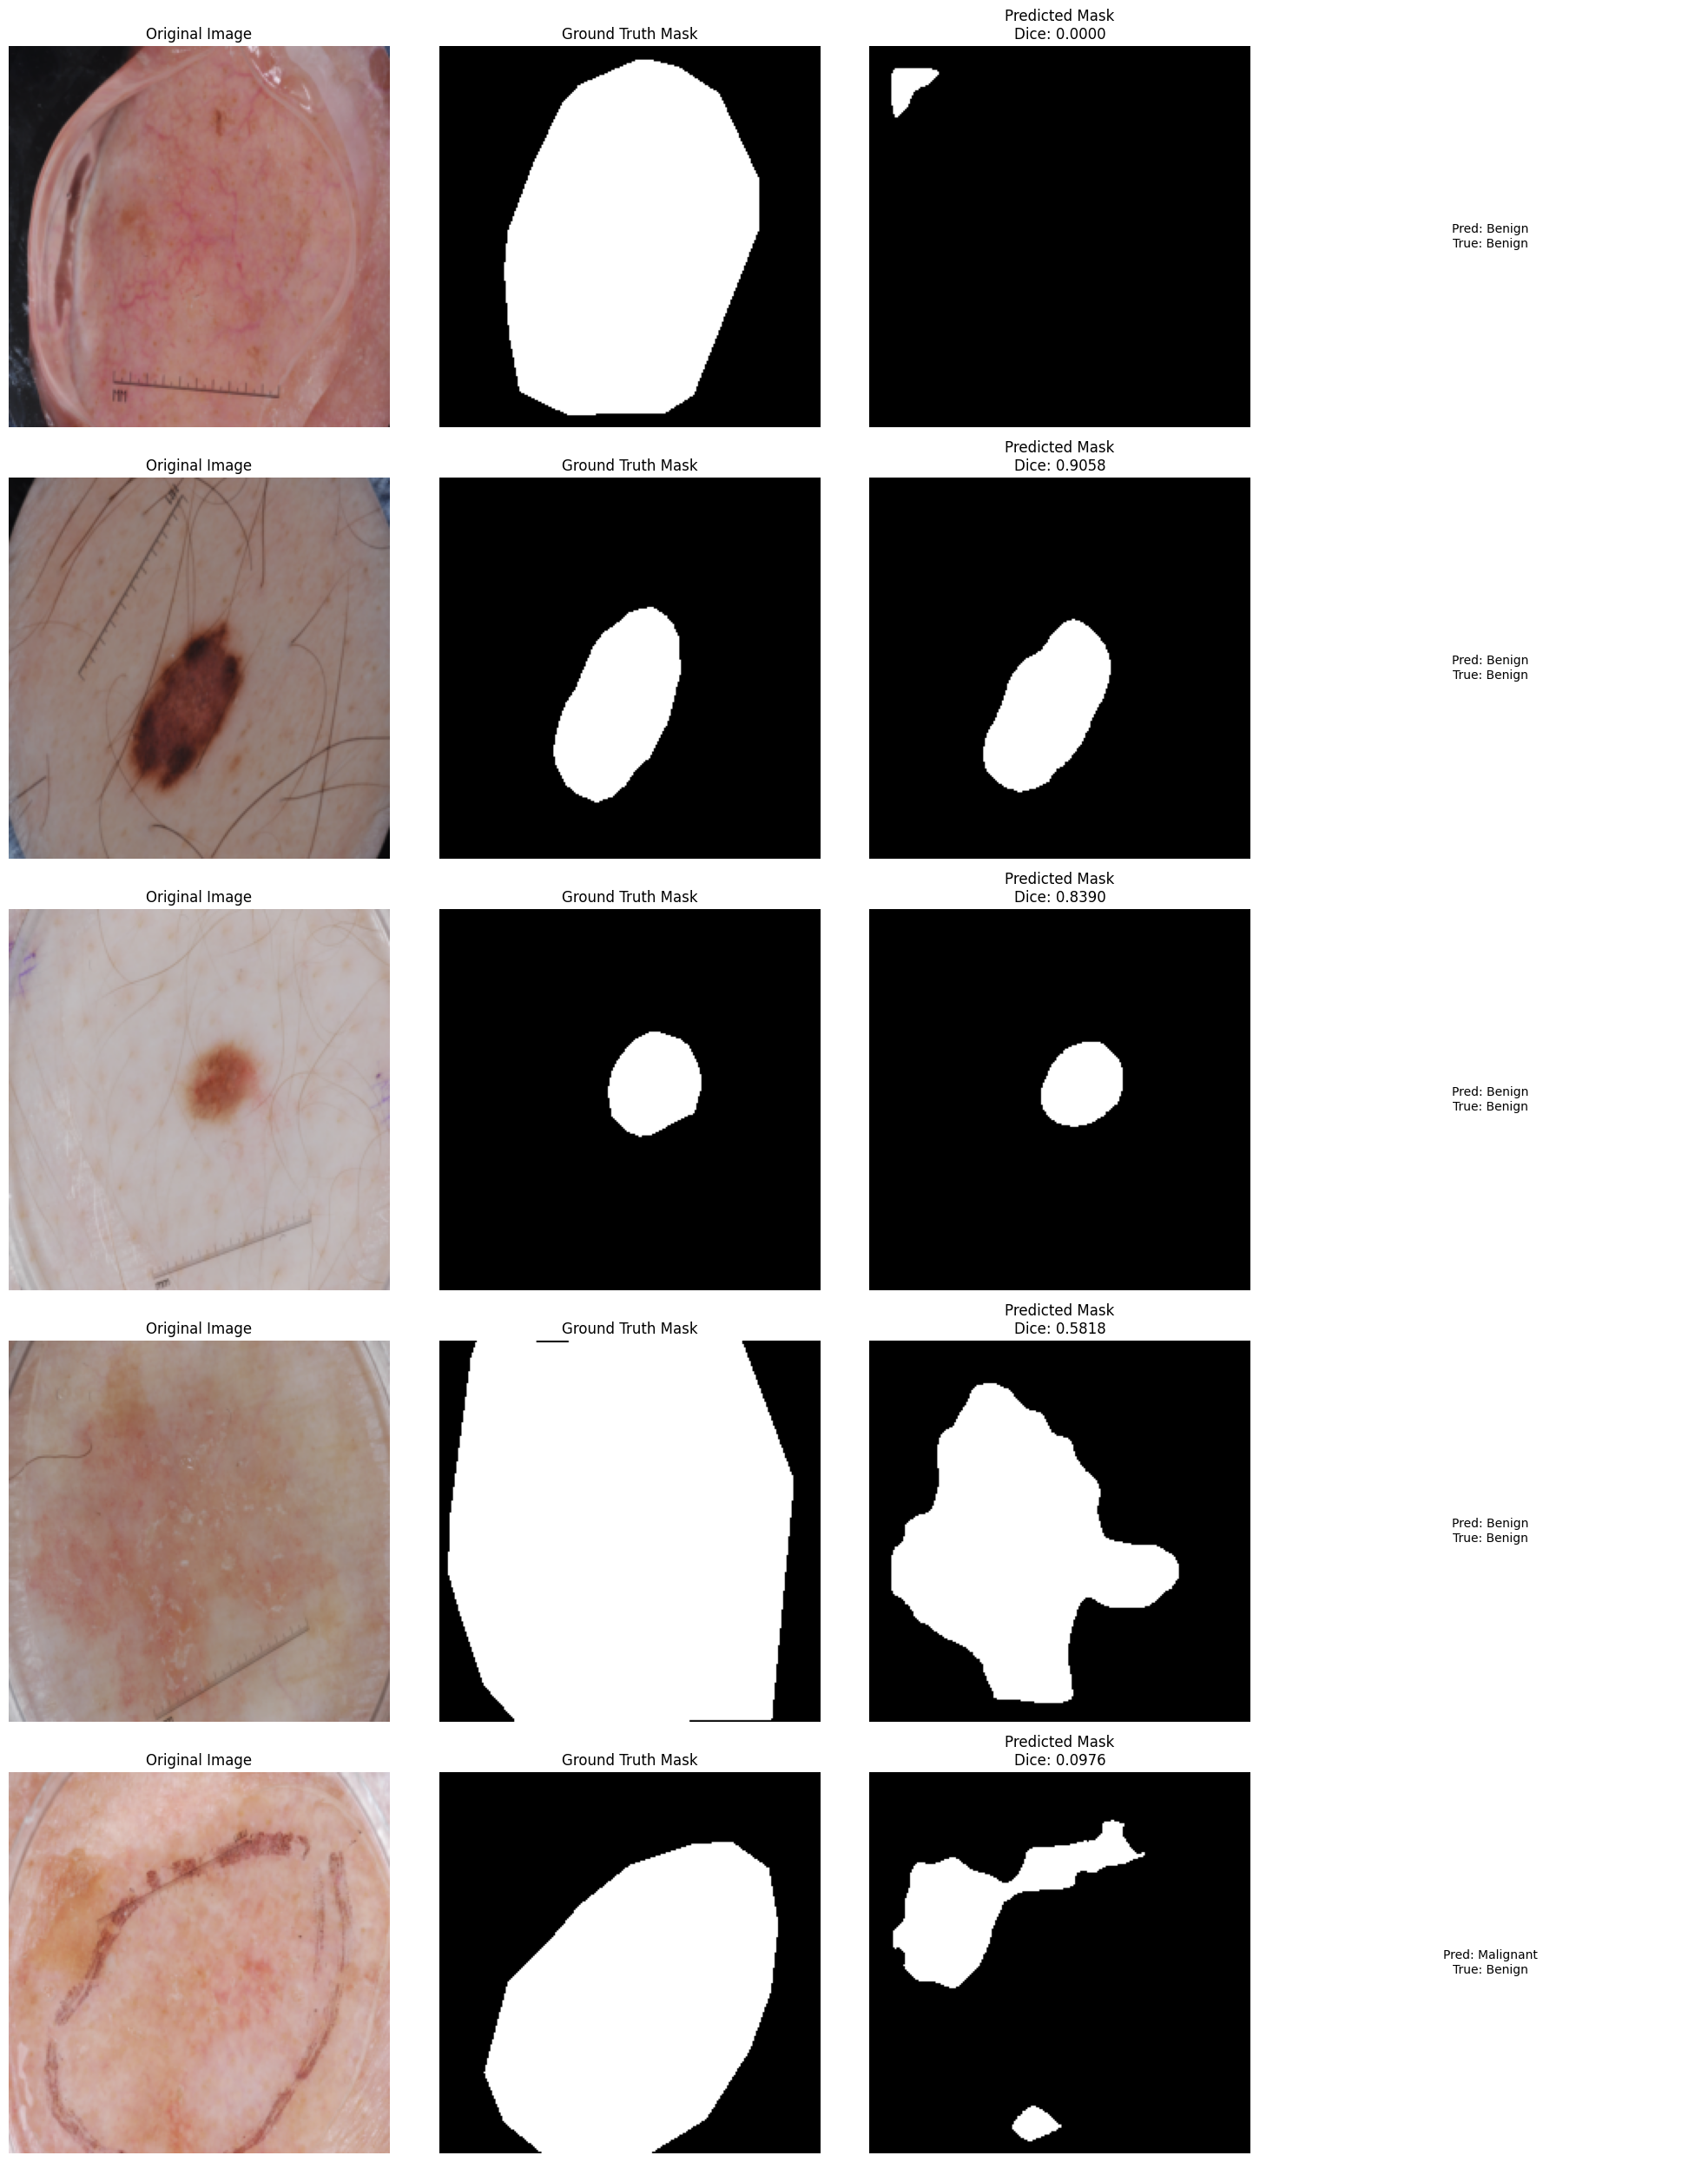

In [18]:
import matplotlib.pyplot as plt

def visualize_samples(model, test_loader, device, num_samples=5):
    model.eval()
    images_to_show = []
    masks_to_show = []
    preds_to_show = []
    labels_to_show = []
    dice_scores_to_show = []

    with torch.no_grad():
        for images, masks, labels in test_loader:
            images = images.to(device)
            masks = masks.to(device)
            labels = labels.to(device).long()

            seg_out, cls_out = model(images)
            preds = torch.sigmoid(seg_out) > 0.5
            pred_labels = torch.argmax(cls_out, dim=1)
            batch_dice = calculate_dice(seg_out, masks)  # Now returns [batch_size]

            # Collect up to 5 samples
            for i in range(min(num_samples - len(images_to_show), images.size(0))):
                images_to_show.append(images[i].cpu().permute(1, 2, 0).numpy())
                masks_to_show.append(masks[i].cpu().squeeze().numpy())
                preds_to_show.append(preds[i].cpu().squeeze().numpy())
                labels_to_show.append(labels[i].item())
                dice_scores_to_show.append(batch_dice[i].item())  # Now works correctly

                if len(images_to_show) == num_samples:
                    break

            if len(images_to_show) == num_samples:
                break

    # Visualization
    label_map_inv = {0: 'Benign', 1: 'Malignant'}
    fig, axes = plt.subplots(num_samples, 4, figsize=(20, num_samples * 5))
    for i in range(num_samples):
        # Original Image
        axes[i, 0].imshow(images_to_show[i])
        axes[i, 0].set_title("Original Image")
        axes[i, 0].axis('off')

        # Ground Truth Mask
        axes[i, 1].imshow(masks_to_show[i], cmap='gray')
        axes[i, 1].set_title("Ground Truth Mask")
        axes[i, 1].axis('off')

        # Predicted Mask
        axes[i, 2].imshow(preds_to_show[i], cmap='gray')
        axes[i, 2].set_title(f"Predicted Mask\nDice: {dice_scores_to_show[i]:.4f}")
        axes[i, 2].axis('off')

        # Classification
        pred_class = label_map_inv[pred_labels[i].cpu().item()]
        true_class = label_map_inv[labels_to_show[i]]
        axes[i, 3].text(0.5, 0.5, f"Pred: {pred_class}\nTrue: {true_class}",
                       horizontalalignment='center', verticalalignment='center')
        axes[i, 3].axis('off')

    plt.tight_layout()
    plt.show()

# Visualize 5 samples
visualize_samples(model, test_loader, device, num_samples=5)